In [1]:
import rasterio
import glob
import rioxarray as rxr
import numpy as np
import matplotlib as mpl
import subprocess as sub

from matplotlib import pyplot as plt
from os.path import join
from pyproj import Transformer
from rasterio.plot import show
from matplotlib import cm

# gdalwarp -t_srs "+proj=longlat +datum=WGS84 +no_defs" DSM_BQ31_2013_1000_2138.tif regridded_DSM.tif


In [ ]:
def reproject_dir(in_dir, out_dir):
    tifs = glob.glob(join(in_dir, r'*.tif'))
    # gdalwarp -t_srs "+proj=longlat +datum=WGS84 +no_defs" DSM_BQ31_2013_1000_2138.tif regridded_DSM.tif
    for i, tif in enumerate(tifs):
        s = sub.getstatusoutput(f'gdalwarp -t_srs "+proj=longlat +datum=WGS84 +no_defs" "{tif}" "{join(out_dir, tif[167:])}"')
        print(s)
        print(f'Converted {(i/len(tifs) * 100):.2f}% of files..')

in_dir = r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/NZGD2000/lds-wellington-city-2layers-GTiff/wellington-city-lidar-1m-dsm-2019-2020'
out_dir = r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/WGS84/DSM'

reproject_dir(in_dir, out_dir)

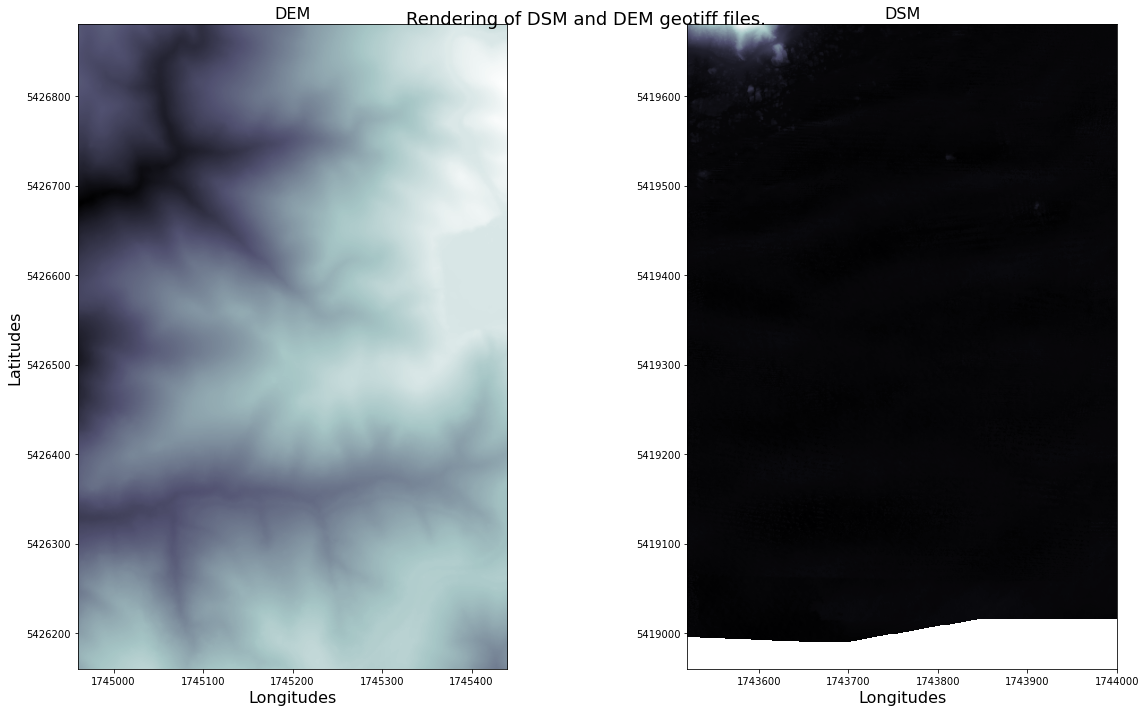

In [18]:
efig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))
fig.suptitle('Rendering of DSM and DEM geotiff files.', fontsize=18)

ax1.set_title('DEM', fontsize=16)
ax1.ticklabel_format(useOffset=False, style='plain')
ax1.set_ylabel('Latitudes', fontsize=16)
ax1.set_xlabel('Longitudes', fontsize=16)

ax2.set_title('DSM', fontsize=16)
ax2.ticklabel_format(useOffset=False, style='plain')
ax2.set_xlabel('Longitudes', fontsize=16)

dems = glob.glob(r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/WGS84/DEM/*.tif')
dsms = glob.glob(r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/WGS84/DSM/*.tif')

for i, dem in enumerate(dems):
    # rgr_dem = rxr.open_rasterio(dem)
    dem_ds = rasterio.open(dem)

    # rgr_dsm = rxr.open_rasterio(dsms[i])
    dsm_ds = rasterio.open(dsms[i])

    dem_im = show(dem_ds, ax=ax1, cmap='bone')
    dsm_im = show(dsm_ds, ax=ax2, cmap='bone')

plt.tight_layout()
# DEM_BQ31_2019_1000_0641.tif

plt.show()
# plt.savefig(r'/home/shaun/Documents/work_dir/climate_sigma/wellington_visualisation.jpeg', dpi=350)

In [32]:
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform

def load_transform_raster(fname):
    """
        Opens a raster file and converts the projection in WGS64 (lat/lon) projection.
        From https://gis.stackexchange.com/questions/129847/
        obtain-coordinates-and-corresponding-pixel-values-from-geotiff-using-python-gdal
    :param fname:
    :return:
    """
    # Read raster
    T0 = fname.transform  # upper-left pixel corner affine transform
    p1 = Proj(fname.crs)
    data = fname.read()  # pixel values

    # All rows and columns
    cols, rows = np.meshgrid(np.arange(data.shape[2]), np.arange(data.shape[1]))

    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: (c, r) * T1

    # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

    # Project all longitudes, latitudes
    p2 = Proj(proj='latlong',datum='WGS84')
    lons, lats = transform(p1, p2, eastings, northings)
    return data[0], lats, lons

In [33]:
DEM_path = r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/lds-wellington-city-2layers-GTiff/wellington-city-lidar-1m-dem-2019-2020'
DSM_path = r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/lds-wellington-city-2layers-GTiff/wellington-city-lidar-1m-dsm-2019-2020'

fig, ax = plt.subplots(1, figsize=(10,12))

plt.margins(0.5)
plt.title('Difference between DSM and DEM (DSM-DEM)', fontsize=18)
plt.xlabel('Latitudes', fontsize=14, labelpad=12)
plt.ylabel('Longitudes', fontsize=14, labelpad=12)

ax.ticklabel_format(useOffset=False, style='plain')

plt.tight_layout()

dems = glob.glob(r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/WGS84/DEM/*.tif')
dsms = glob.glob(r'/mnt/temp/Projects/Small Contracts/DEM_DSM_region_elevation/raw/wellington_2019_2020/WGS84/DSM/*.tif')

for i, dem in enumerate(dems):
    # rgr_dem = rxr.open_rasterio(dem)
    dem_ds = rasterio.open(dem)

    # rgr_dsm = rxr.open_rasterio(dsms[i])
    dsm_ds = rasterio.open(dsms[i])

    dem_heights, dem_lats, dem_lons = load_transform_raster(dem_ds)
    dsm_heights, dsm_lats, dsm_lons = load_transform_raster(dsm_ds)

    heights = dsm_heights - dem_heights

    plt.contourf(dsm_lats, dsm_lons, heights, cmap='viridis')

    # dem_im = show(dem_ds, ax=ax1, cmap='bone')
    # dsm_im = show(dsm_ds, ax=ax2, cmap='bone')

plt.colorbar()
plt.tight_layout()
# DEM_BQ31_2019_1000_0641.tif

plt.show()
# plt.savefig(r'/home/shaun/Documents/work_dir/climate_sigma/wellington_visualisation.jpeg', dpi=350)

NameError: name 'heights' is not defined